# Chapter 3: Classification
Notes for *Hands on Machine Learning with Scikit by Aurelien Geron*. This is on Chapter 3: Classification, where it explains the fundamentals on how Machine Learning identify one group from the other using statistics.

# Getting Started
The dataset used is the *MNIST*, which is a collection of handwritten numbers in the format of image pixels. The goal is to have the machine tell us what number is in each image.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

You can download a copy of the dataset from sklearn. This gets updated often, which is why it is different on the book.

In [2]:
df, target = mnist["data"], mnist["target"]

We separate the data from the labels. I usually use *df* for the main data and *target* as the labels. *labels* are the answer keys, which tells us which number it is.

In [14]:
print('dataframe', df.shape)
print('target', target.shape)

dataframe (70000, 784)
target (70000,)


There are 70,000 numbers in the dataframe and the target. Each image has 784 pixel information.

## Split Train Test
We split the data between *Train* and *Test*. We use the *Train* for majority of the time. The *Test* is only used at the very end, where we validate our resultes.

In [19]:
train_df, test_df, train_target, test_target = df[:60000], df[60000:], target[:60000], target[60000:]

Conviniently, the MINST dataset is already dividied into Train and Test. The first 60k rows is the Train and the rest are the Test. We just need to get them and place them into our values.

In [20]:
import numpy as np
shuffle_index = np.random.permutation(60000)
train_df, train_target = train_df.iloc[shuffle_index], train_target.iloc[shuffle_index]

There is a chance that the numbers are in order in a way that it will affect our models. So, it would be best to shuffle them randomly like playing cards to get unbaised results.

# Explore Data


0


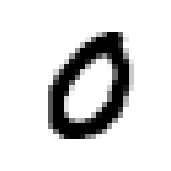

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = train_df.iloc[0].values
roll = train_target.iloc[0]
print(roll)
plt.figure(figsize=(2,2))
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

# Clean Data

In [8]:
import numpy as np
train_target = train_target.astype(np.uint8)
test_target = test_target.astype(np.uint8)

# Machine Learning

## Training a Binary Classifier

In [9]:
train_roll = (train_target==roll)
test_roll = (test_target==roll)

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(train_df, train_roll)

ValueError: The number of classes has to be greater than one; got 1 class

In [ ]:
sgd_clf.predict([some_digit])

## Why Accuracy Sucks

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, train_df, train_9, cv=3, scoring="accuracy")


Very High Accuracy Results. You got sgd_clf, which was fitted with TRAIN dataset and evaluated the number of times it is correct using K-fold evaluation. You get high results because majority of the values are not 9, so you would be correct 90% of the time that the value is not 9.

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_roll_clf = Never5Classifier()
cross_val_score(never_roll_clf, train_df, train_roll, cv=3, scoring="accuracy")

Accuracy is generally not a good measure of performance for classifiers. About 10% of the images are 5s, so if you always guess that an image is not a 5, then you will be right 90% of the time.

## Confusion Matrix
This counts the numner of times the instances of class A are classified as class B. 

In [51]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, train_df, train_roll, cv=3)

In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix(train_roll, y_train_pred)

array([[53357,   725],
       [  539,  5379]], dtype=int64)

In [53]:
y_train_pred_perfect = train_roll
confusion_matrix(train_roll, y_train_pred_perfect)

array([[54082,     0],
       [    0,  5918]], dtype=int64)

In [59]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(train_roll, y_train_pred)
precision

0.8812254259501966

In [60]:
recall = recall_score(train_roll, y_train_pred)
recall

0.9089219330855018

### F1 score
Harmonic mean gives more weigh to low values. Regular mean will weight the 2 values equal.

In [65]:
from sklearn.metrics import f1_score
print('mean: ', (precision + recall) / 2)
print('f1: ', f1_score(train_roll, y_train_pred))

mean:  0.4411127129750983
f1:  0.8948594243886209


### Threshold

In [57]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([5121.19071847])

In [58]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])